In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import lightning as L
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform=transforms.Compose([transforms.ToTensor(),])

In [3]:
train=datasets.MNIST(root="./data",train=True,download=True,transform=transform)
test=datasets.MNIST(root="./data",train=False,download=True,transform=transform)

In [4]:
dl=DataLoader(train,batch_size=1280,shuffle=True,num_workers=3)
dltest=DataLoader(test,batch_size=1000,num_workers=3)

In [5]:
class LocalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.window_size = window_size

    def forward(self, x):
        B, N, C = x.shape
        mask = self._generate_local_mask(N, self.window_size).to(x.device)
        out, _ = self.attn(x, x, x, attn_mask=mask)
        return out

    def _generate_local_mask(self, seq_len, window):
        mask = torch.full((seq_len, seq_len), float('-inf'))
        for i in range(seq_len):
            start = max(0, i - window)
            end = min(seq_len, i + window + 1)
            mask[i, start:end] = 0
        return mask



In [6]:

class LocalAttentionNet(L.LightningModule):
    def __init__(self, patch_size=4, embed_dim=64, num_heads=4, num_classes=10, depth=2, window_size=2):
        super().__init__()
        L.seed_everything(42)

        self.patch_size = patch_size
        self.n_patches = (28 // patch_size) ** 2
        self.embedding = nn.Linear(patch_size * patch_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches, embed_dim))

        self.blocks = nn.Sequential(*[
            nn.Sequential(
                LocalSelfAttention(embed_dim, num_heads, window_size),
                nn.LayerNorm(embed_dim),
                nn.Sequential(
                    nn.Linear(embed_dim, embed_dim * 2),
                    nn.ReLU(),
                    nn.Linear(embed_dim * 2, embed_dim),
                ),
                nn.LayerNorm(embed_dim),
            )
            for _ in range(depth)
        ])

        self.cls_head = nn.Linear(embed_dim, num_classes)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        B = x.shape[0]
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, 1, -1, self.patch_size, self.patch_size)
        x = x.view(B, self.n_patches, -1)  # (B, N, patch_dim)
        x = self.embedding(x) + self.pos_embedding  # (B, N, embed_dim)

        for attention, norm1, ff, norm2 in self.blocks:
            x = attention(x) + x
            x = norm1(x)
            x = ff(x) + x
            x = norm2(x)

        x = x.mean(dim=1)
        return self.cls_head(x)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        loss = self.loss(out, y)
        return loss


In [12]:
model = LocalAttentionNet()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, dl)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | embedding    | Linear           | 1.1 K  | train
1 | blocks       | Sequential       | 66.9 K | train
2 | cls_head     | Linear           | 650    | train
3 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 3.1 K  | n/a  
----------------------------------------------------------
71.8 K    Trainable params
0         Non-trainable params
71.8 K    Total params
0.287     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
for batch_num, (image, label) in enumerate(dl):
    
    prediction = model(image)
    
    probabilities = torch.softmax(prediction, dim=1)

    predicted_label = torch.argmax(probabilities, dim=1)
    
    print("Predicted label:", predicted_label)
    print("Original label:", label)
    print("\n")

Predicted label: tensor([7, 8, 1,  ..., 4, 8, 6])
Original label: tensor([7, 8, 1,  ..., 4, 8, 6])


Predicted label: tensor([0, 6, 6,  ..., 9, 6, 1])
Original label: tensor([0, 6, 6,  ..., 9, 6, 1])


Predicted label: tensor([1, 2, 9,  ..., 7, 0, 2])
Original label: tensor([1, 2, 9,  ..., 7, 0, 2])


Predicted label: tensor([1, 0, 6,  ..., 3, 2, 9])
Original label: tensor([1, 0, 6,  ..., 3, 2, 9])


Predicted label: tensor([3, 4, 3,  ..., 4, 3, 5])
Original label: tensor([3, 4, 3,  ..., 4, 3, 5])


Predicted label: tensor([6, 6, 9,  ..., 9, 4, 2])
Original label: tensor([6, 6, 9,  ..., 7, 4, 2])


Predicted label: tensor([7, 2, 8,  ..., 3, 6, 7])
Original label: tensor([7, 2, 8,  ..., 3, 6, 7])


Predicted label: tensor([1, 2, 2,  ..., 4, 0, 3])
Original label: tensor([1, 2, 7,  ..., 4, 0, 3])


Predicted label: tensor([6, 5, 6,  ..., 4, 3, 6])
Original label: tensor([6, 5, 6,  ..., 4, 5, 5])


Predicted label: tensor([8, 8, 3,  ..., 3, 9, 3])
Original label: tensor([8, 8, 3,  ..., 3,

In [14]:
actual_labels_array = []
predicted_labels_array = []


for batch_num, (image, label) in enumerate(dltest):
    
    prediction = model(image)
    
    probabilities = torch.softmax(prediction, dim=1)
    
    predicted_label = torch.argmax(probabilities, dim=1)
    actual_labels_array.extend(label.tolist())
    predicted_labels_array.extend(predicted_label.tolist())
    print("Predicted label:", predicted_label)
    print("Original label:", label)
    print("\n")

Predicted label: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        3, 9, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 2, 0, 4, 9, 3, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 3, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1,
        0, 9, 0, 5, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 5, 5, 5, 7, 2, 8, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1,
        5, 5, 8, 7, 2, 3, 0, 6, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7,
        9, 1, 0, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4,
        1, 5, 8, 2, 9, 

In [15]:
torch.sum(torch.eq(torch.tensor(label), predicted_label)) / len(predicted_label)

/tmp/ipykernel_1371/513388415.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.sum(torch.eq(torch.tensor(label), predicted_label)) / len(predicted_label)


tensor(0.9500)

Predicted are [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4] 
 Actual are[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]


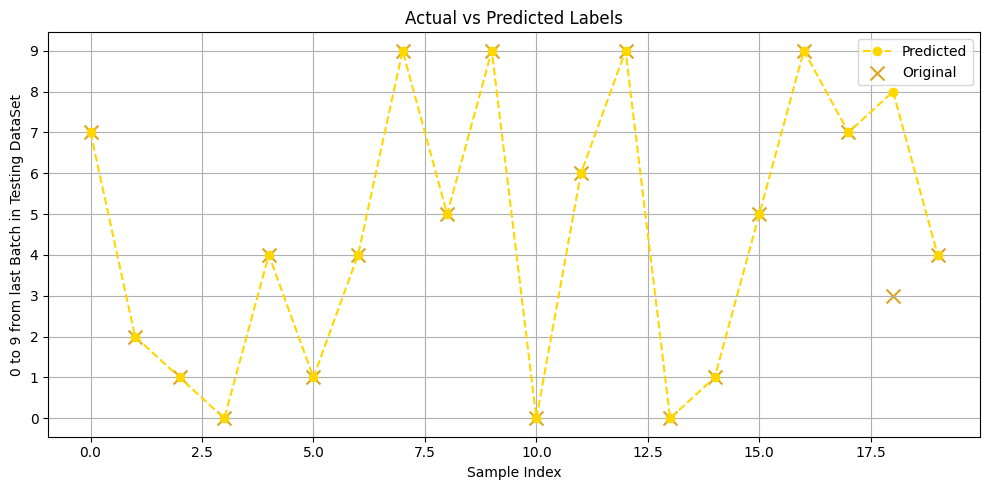

In [16]:
import matplotlib.pyplot as plt

N = 20
print(f"Predicted are {predicted_labels_array[:N]}",f"\n Actual are{actual_labels_array[:N]}")
x_axis = list(range(N))

plt.figure(figsize=(10, 5))

plt.plot(x_axis,predicted_labels_array[:N], label="Predicted", linestyle='--', marker='o', color='gold')
plt.scatter(x_axis, actual_labels_array[:N] , label="Original", color='goldenrod', marker='x', s=100)

plt.xlabel("Sample Index")
plt.ylabel("0 to 9 from last Batch in Testing DataSet")
plt.title("Actual vs Predicted Labels")
plt.legend()
plt.grid(True)
plt.yticks(range(10))
plt.tight_layout()
plt.show()